В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [5]:
from google.colab import drive

drive.mount('/content/drive')
raw_df = pd.read_csv("drive/MyDrive/ML Course/bank-customer/train.csv")

Mounted at /content/drive


In [6]:
target_col = 'Exited'
input_cols = [col for col in raw_df.columns if col not in ['id', 'CustomerId', 'Surname', target_col]]

In [7]:
train_df, val_df = split_train_val(raw_df, target_col=target_col, test_size=0.2, random_state=42)

In [10]:
X_train, y_train = separate_inputs_targets(train_df, input_cols, target_col)
X_val, y_val = separate_inputs_targets(val_df, input_cols, target_col)

In [12]:
print(f"Розмір X_train: {X_train.shape}")
print(f"Розмір y_train: {y_train.shape}")
print(f"Розмір X_val: {X_val.shape}")
print(f"Розмір y_val: {y_val.shape}")
print(f"Використані ознаки: {input_cols}")

Розмір X_train: (12000, 10)
Розмір y_train: (12000,)
Розмір X_val: (3000, 10)
Розмір y_val: (3000,)
Використані ознаки: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [13]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01
3365,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98
12236,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [18]:
X_train.dtypes

,0
CreditScore,float64
Geography,object
Gender,object
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64
EstimatedSalary,float64


In [14]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

categorical_cols

['Geography', 'Gender']

In [19]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [20]:
X_train.dtypes

,0
CreditScore,float64
Geography,category
Gender,category
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64
EstimatedSalary,float64


In [21]:
X_train.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [31]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    enable_categorical=True,
    use_label_encoder=False,
    tree_method='hist',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    missing=np.nan,
    device='cuda'
)

xgb_clf.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

print(classification_report(y_train, train_pred, digits=4))
print(classification_report(y_val, val_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:10:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0     0.9347    0.9703    0.9522      9558
         1.0     0.8633    0.7346    0.7938      2442

    accuracy                         0.9223     12000
   macro avg     0.8990    0.8525    0.8730     12000
weighted avg     0.9202    0.9223    0.9199     12000

              precision    recall  f1-score   support

         0.0     0.9211    0.9531    0.9369      2390
         1.0     0.7875    0.6803    0.7300       610

    accuracy                         0.8977      3000
   macro avg     0.8543    0.8167    0.8334      3000
weighted avg     0.8940    0.8977    0.8948      3000



In [36]:
train_probas_xgb = xgb_clf.predict_proba(X_train)[:, 1]
val_probas_xgb = xgb_clf.predict_proba(X_val)[:, 1]

train_roc_auc_xgb = roc_auc_score(y_train, train_probas_xgb)
val_roc_auc_xgb = roc_auc_score(y_val, val_probas_xgb)

print(f"AUROC на тренувальному наборі (XGBoost): {train_roc_auc_xgb:.4f}")
print(f"AUROC на валідаційному наборі (XGBoost):  {val_roc_auc_xgb:.4f}")

AUROC на тренувальному наборі (XGBoost): 0.9607
AUROC на валідаційному наборі (XGBoost):  0.9336


**Висновок**

Отриману модель вважаю хорошою. AUROC на валідаційному наборі = 0.9336, що є високим і що свідчить про те, що модель має гарну узагальнуючу здатність і добре справляється з задачею прогнозування відтоку клієнтів.

Розрив між тренувальним і валідаційним AUROC становить лише 0.0271. Це вказує на те що модель має незначні ознакит high variance, але все одно смію сказати що модель є добре збалансованою.

В порівнянні з попередніми моделями можу сказати що модель покращалась:
  - Decision Tree (з ручним підбором): AUROC був 0.9219.

  - Decision Tree (з RandomizedSearchCV): AUROC був 0.9166.

  

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [38]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [42]:
def objective(params: Dict[str, Any]) -> Dict[str, Any]:
    """
    Objective function for Hyperopt.
    It trains an XGBoost model with given parameters and returns the negative AUROC on the validation set.
    """

    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    clf = xgb.XGBClassifier(
        **params,
        objective='binary:logistic',
        eval_metric='auc',
        enable_categorical=True,
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

    val_probas = clf.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, val_probas)

    loss = -roc_auc

    return {'loss': loss, 'status': STATUS_OK, 'model': clf}

In [39]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

In [44]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 20/20 [00:20<00:00,  1.00s/trial, best loss: -0.9367494341175664]


In [45]:
# виведіть найкращі значення гіперпараметрів

best_params = best.copy()
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
print(best_params)

{'colsample_bytree': np.float64(0.6312082363473505), 'gamma': np.float64(0.11726609768193053), 'learning_rate': np.float64(0.015820166194736453), 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': np.float64(0.3506832932733329), 'reg_lambda': np.float64(0.10308206613656157), 'subsample': np.float64(0.7299796125452439)}


In [47]:
# створіть в окремій зміній final_clf модель XGBoostClassifier з найкращими гіперпараметрами
# навчіть модель final_clf

final_clf = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    enable_categorical=True,
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

final_clf.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6312082363473505), device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=np.float64(0.11726609768193053), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.015820166194736453), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, ...)

In [48]:
# оцініть якість моделі final_clf на тренувальній і валідаційній вибірках з допомогою AUROC.

train_probas_final = final_clf.predict_proba(X_train)[:, 1]
val_probas_final = final_clf.predict_proba(X_val)[:, 1]

train_roc_auc_final = roc_auc_score(y_train, train_probas_final)
val_roc_auc_final = roc_auc_score(y_val, val_probas_final)

print(f"AUROC на тренувальному наборі (final_clf): {train_roc_auc_final:.4f}")
print(f"AUROC на валідаційному наборі (final_clf):  {val_roc_auc_final:.4f}")

AUROC на тренувальному наборі (final_clf): 0.9482
AUROC на валідаційному наборі (final_clf):  0.9367


**Висновок**

Продуктивність моделі final_clf є дуже сильною моделлю. AUROC на валідаційному наборі дорівнює 0.9367, що є найвищим показником, який вдалося отримали досі. Це свідчить про те, що оптимізація за допомогою Hyperopt дозволила знайти комбінацію гіперпараметрів, яка найкраще підходить для цих даних.

Розрив між тренувальним та валідаційним AUROC становить 0.0115. Цей розрив є дуже малим, що означає, що модель є надзвичайно добре збалансованою між bias та variance. Вона має високу узагальнюючу здатність і практично не перенавчається на тренувальних даних.

Ця модель краща за попередню. Оптимізація за допомогою Hyperopt дозволила досягти невеликого, але помітного покращення AUROC на валідаційному наборі.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [49]:
import lightgbm as lgb

In [50]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in categorical_cols]
print(f"Індекси категоріальних колонок: {cat_feature_indexes}")

Індекси категоріальних колонок: [1, 2]


In [51]:
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

In [52]:
lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              categorical_feature=cat_feature_indexes,
              callbacks=[lgb.early_stopping(10, verbose=False)])

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(colsample_bytree=0.8, max_depth=5, metric='auc', n_jobs=-1,
               objective='binary', random_state=42, subsample=0.8)

In [53]:
train_probas_lgbm = lgb_model.predict_proba(X_train)[:, 1]
val_probas_lgbm = lgb_model.predict_proba(X_val)[:, 1]

train_roc_auc_lgbm = roc_auc_score(y_train, train_probas_lgbm)
val_roc_auc_lgbm = roc_auc_score(y_val, val_probas_lgbm)

print(f"AUROC на тренувальному наборі (LightGBM): {train_roc_auc_lgbm:.4f}")
print(f"AUROC на валідаційному наборі (LightGBM):  {val_roc_auc_lgbm:.4f}")

AUROC на тренувальному наборі (LightGBM): 0.9440
AUROC на валідаційному наборі (LightGBM):  0.9354


**Висновок**

Результати моделі гарні, які свдчать про високу продуктивність. AUROC на валідаційному наборі = 0.9354, що є дуже високим. Це говорить про те, що модель гарно справляється з прогнозуванням на нових, невідомих даних.

Розрив між тренувальним та валідаційним AUROC становить 0.0086. Цей розрив є дуже малим. Це означає, що модель є добре збалансованою. Вона не "запам'ятовує" тренувальні дані (низький variance) і має достатньо складності, щоб ефективно моделювати патерни (низький bias).

Якість моделі порівнянна з найкращою моделлю XGBoost, але трохи поступається їй. Різниця становить лише 0.0013 (0.9367 − 0.9354).



5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [54]:
def objective_lgb(params: Dict[str, Any]) -> Dict[str, Any]:

    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    params['min_child_samples'] = int(params['min_child_samples'])

    clf = lgb.LGBMClassifier(
        **params,
        objective='binary',
        metric='auc',
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            categorical_feature=cat_feature_indexes,
            callbacks=[lgb.early_stopping(10, verbose=False)])

    val_probas = clf.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, val_probas)

    loss = -roc_auc

    return {'loss': loss, 'status': STATUS_OK}

In [55]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'min_child_samples': hp.quniform('min_child_samples', 20, 50, 5),
}


In [ ]:
trials = Trials()
best = fmin(
    fn=objective_lgb,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=np.random.default_rng(42)
)

In [57]:
# виведіть найкращі значення гіперпараметрів

best_lgb_params = best.copy()
best_lgb_params['n_estimators'] = int(best_lgb_params['n_estimators'])
best_lgb_params['max_depth'] = int(best_lgb_params['max_depth'])
best_lgb_params['num_leaves'] = int(best_lgb_params['num_leaves'])
best_lgb_params['min_child_samples'] = int(best_lgb_params['min_child_samples'])
print(best_lgb_params)

{'colsample_bytree': np.float64(0.7009692021980518), 'learning_rate': np.float64(0.05743704894317722), 'max_depth': 4, 'min_child_samples': 35, 'n_estimators': 150, 'num_leaves': 80, 'reg_alpha': np.float64(0.5924534133258075), 'reg_lambda': np.float64(0.21221711699333523), 'subsample': np.float64(0.7615110681047916)}


In [ ]:
# створіть в окремій зміній final_lgb_clf модель LightGBM з найкращими гіперпараметрами
# навчіть модель final_lgb_clf

final_lgb_clf = lgb.LGBMClassifier(
    **best_lgb_params,
    objective='binary',
    metric='auc',
    random_state=42,
    n_jobs=-1
)

final_lgb_clf.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  categorical_feature=cat_feature_indexes,
                  callbacks=[lgb.early_stopping(10, verbose=False)])

In [60]:
# оцініть якість моделі final_lgb_clf на тренувальній і валідаційній вибірках з допомогою AUROC.

train_probas_final_lgb = final_lgb_clf.predict_proba(X_train)[:, 1]
val_probas_final_lgb = final_lgb_clf.predict_proba(X_val)[:, 1]

train_roc_auc_final_lgb = roc_auc_score(y_train, train_probas_final_lgb)
val_roc_auc_final_lgb = roc_auc_score(y_val, val_probas_final_lgb)

print(f"AUROC на тренувальному наборі (final_lgb_clf): {train_roc_auc_final_lgb:.4f}")
print(f"AUROC на валідаційному наборі (final_lgb_clf):  {val_roc_auc_final_lgb:.4f}")


AUROC на тренувальному наборі (final_lgb_clf): 0.9439
AUROC на валідаційному наборі (final_lgb_clf):  0.9369


**Висновок**

Продуктивність моделі final_lgb_clf є дуже сильною. AUROC на валідаційному наборі 0.9369 є найвищим показником, який довелося отримати досі. Це свідчить про те, що оптимізація за допомогою Hyperopt дозволила знайти комбінацію гіперпараметрів, яка найкраще підходить для цих даних.

Розрив між тренувальним та валідаційним AUROC становить всього 0.007. Цей розрив є вкрай малим. Це означає, що модель є надзвичайно добре збалансованою між bias та variance. Вона має високу узагальнюючу здатність і практично не перенавчається на тренувальних даних, що є ідеальним сценарієм.

Оптимізований LightGBM виявився найкращою моделлю, яку ми побудували в цьому завданні. Він не тільки перевершив початкову модель LightGBM, а й ледь помітно випередив вашу найкращу модель XGBoost.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

Я обираю оптимізовану модель LightGBM, яку ми отримали в Завданні 5 (final_lgb_clf).

- Найвища продуктивність. Ця модель показала найвищий AUROC на валідаційному наборі (0.9369), що робить її найкращою з усіх, які ми тренували в цьому блоці завдань.

- Відмінний баланс: Розрив між тренувальним (0.9439) та валідаційним (0.9369) AUROC є мінімальним (0.007), що свідчить про ідеальний баланс між bias та variance, тобто модель чудово узагальнює на нові дані і не перенавчається.

- Ефективність: LightGBM відомий своєю швидкістю та ефективністю, що робить його чудовим вибором для практичного застосування.

Таким чином, оптимізований LightGBM є найбільш надійною та продуктивною моделлю для цієї задачі.

In [69]:
github_raw_url = 'https://raw.githubusercontent.com/tototututo/python_for_ds_tasks/refs/heads/main/HW%202.3/process_bank_churn.py'

!wget -O process_bank_churn.py {github_raw_url}

--2025-08-03 09:56:10--  https://raw.githubusercontent.com/tototututo/python_for_ds_tasks/refs/heads/main/HW%202.3/process_bank_churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12772 (12K) [text/plain]
Saving to: ‘process_bank_churn.py’

process_bank_churn. 100%[===================>]  12.47K  --.-KB/s    in 0s      

2025-08-03 09:56:10 (79.6 MB/s) - ‘process_bank_churn.py’ saved [12772/12772]



In [71]:
from process_bank_churn import preprocess_data, preprocess_new_data, identify_features

In [100]:
raw_data_path = "drive/MyDrive/ML Course/bank-customer/train.csv"
test_data_path = "drive/MyDrive/ML Course/bank-customer/test.csv"
output_submission_path = 'submission_dt_random_search_best.csv'

raw_df = pd.read_csv(raw_data_path)

In [101]:
target_col = 'Exited'
input_cols = [col for col in raw_df.columns if col not in ['id', 'CustomerId', 'Surname', target_col]]
train_df, val_df = split_train_val(raw_df, target_col=target_col, test_size=0.2, random_state=42)
X_train, y_train = separate_inputs_targets(train_df, input_cols, target_col)
X_val, y_val = separate_inputs_targets(val_df, input_cols, target_col)
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
  X_train[col] = X_train[col].astype('category')
  X_val[col] = X_val[col].astype('category')
cat_feature_indexes = [X_train.columns.get_loc(col) for col in categorical_cols]

best_lgb_params = {k: int(v) if k in ['n_estimators', 'max_depth', 'num_leaves', 'min_child_samples'] else v for k, v in best.items()}

In [102]:
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

In [ ]:
for col in categorical_cols:
    X_full_train[col] = X_full_train[col].astype('category')

final_lgb_clf = lgb.LGBMClassifier(
    **best_lgb_params,
    objective='binary',
    metric='auc',
    random_state=42,
    n_jobs=-1
)

final_lgb_clf.fit(X_full_train, y_full_train,
                  categorical_feature=cat_feature_indexes)

In [104]:
test_raw_df = pd.read_csv(test_data_path)

In [105]:
def identify_features(df, target_col):
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        if target_col in numeric_cols:
            numeric_cols.remove(target_col)
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        return numeric_cols, categorical_cols

In [106]:
numeric_cols, categorical_cols_test = identify_features(test_raw_df, target_col='Exited')

for col in categorical_cols_test:
    test_raw_df[col] = test_raw_df[col].astype('category')


In [107]:
X_test_processed = test_raw_df[X_full_train.columns]

In [108]:
test_predictions_proba = final_lgb_clf.predict_proba(X_test_processed)[:, 1]

In [109]:
submission_df = pd.DataFrame({
    'id': test_raw_df['id'],
    'Exited': test_predictions_proba
})

In [110]:
submission_df.head()

,id,Exited
0,15000,0.115589
1,15001,0.014127
2,15002,0.066908
3,15003,0.602318
4,15004,0.027814


In [111]:
submission_df.to_csv(output_submission_path, index=False)

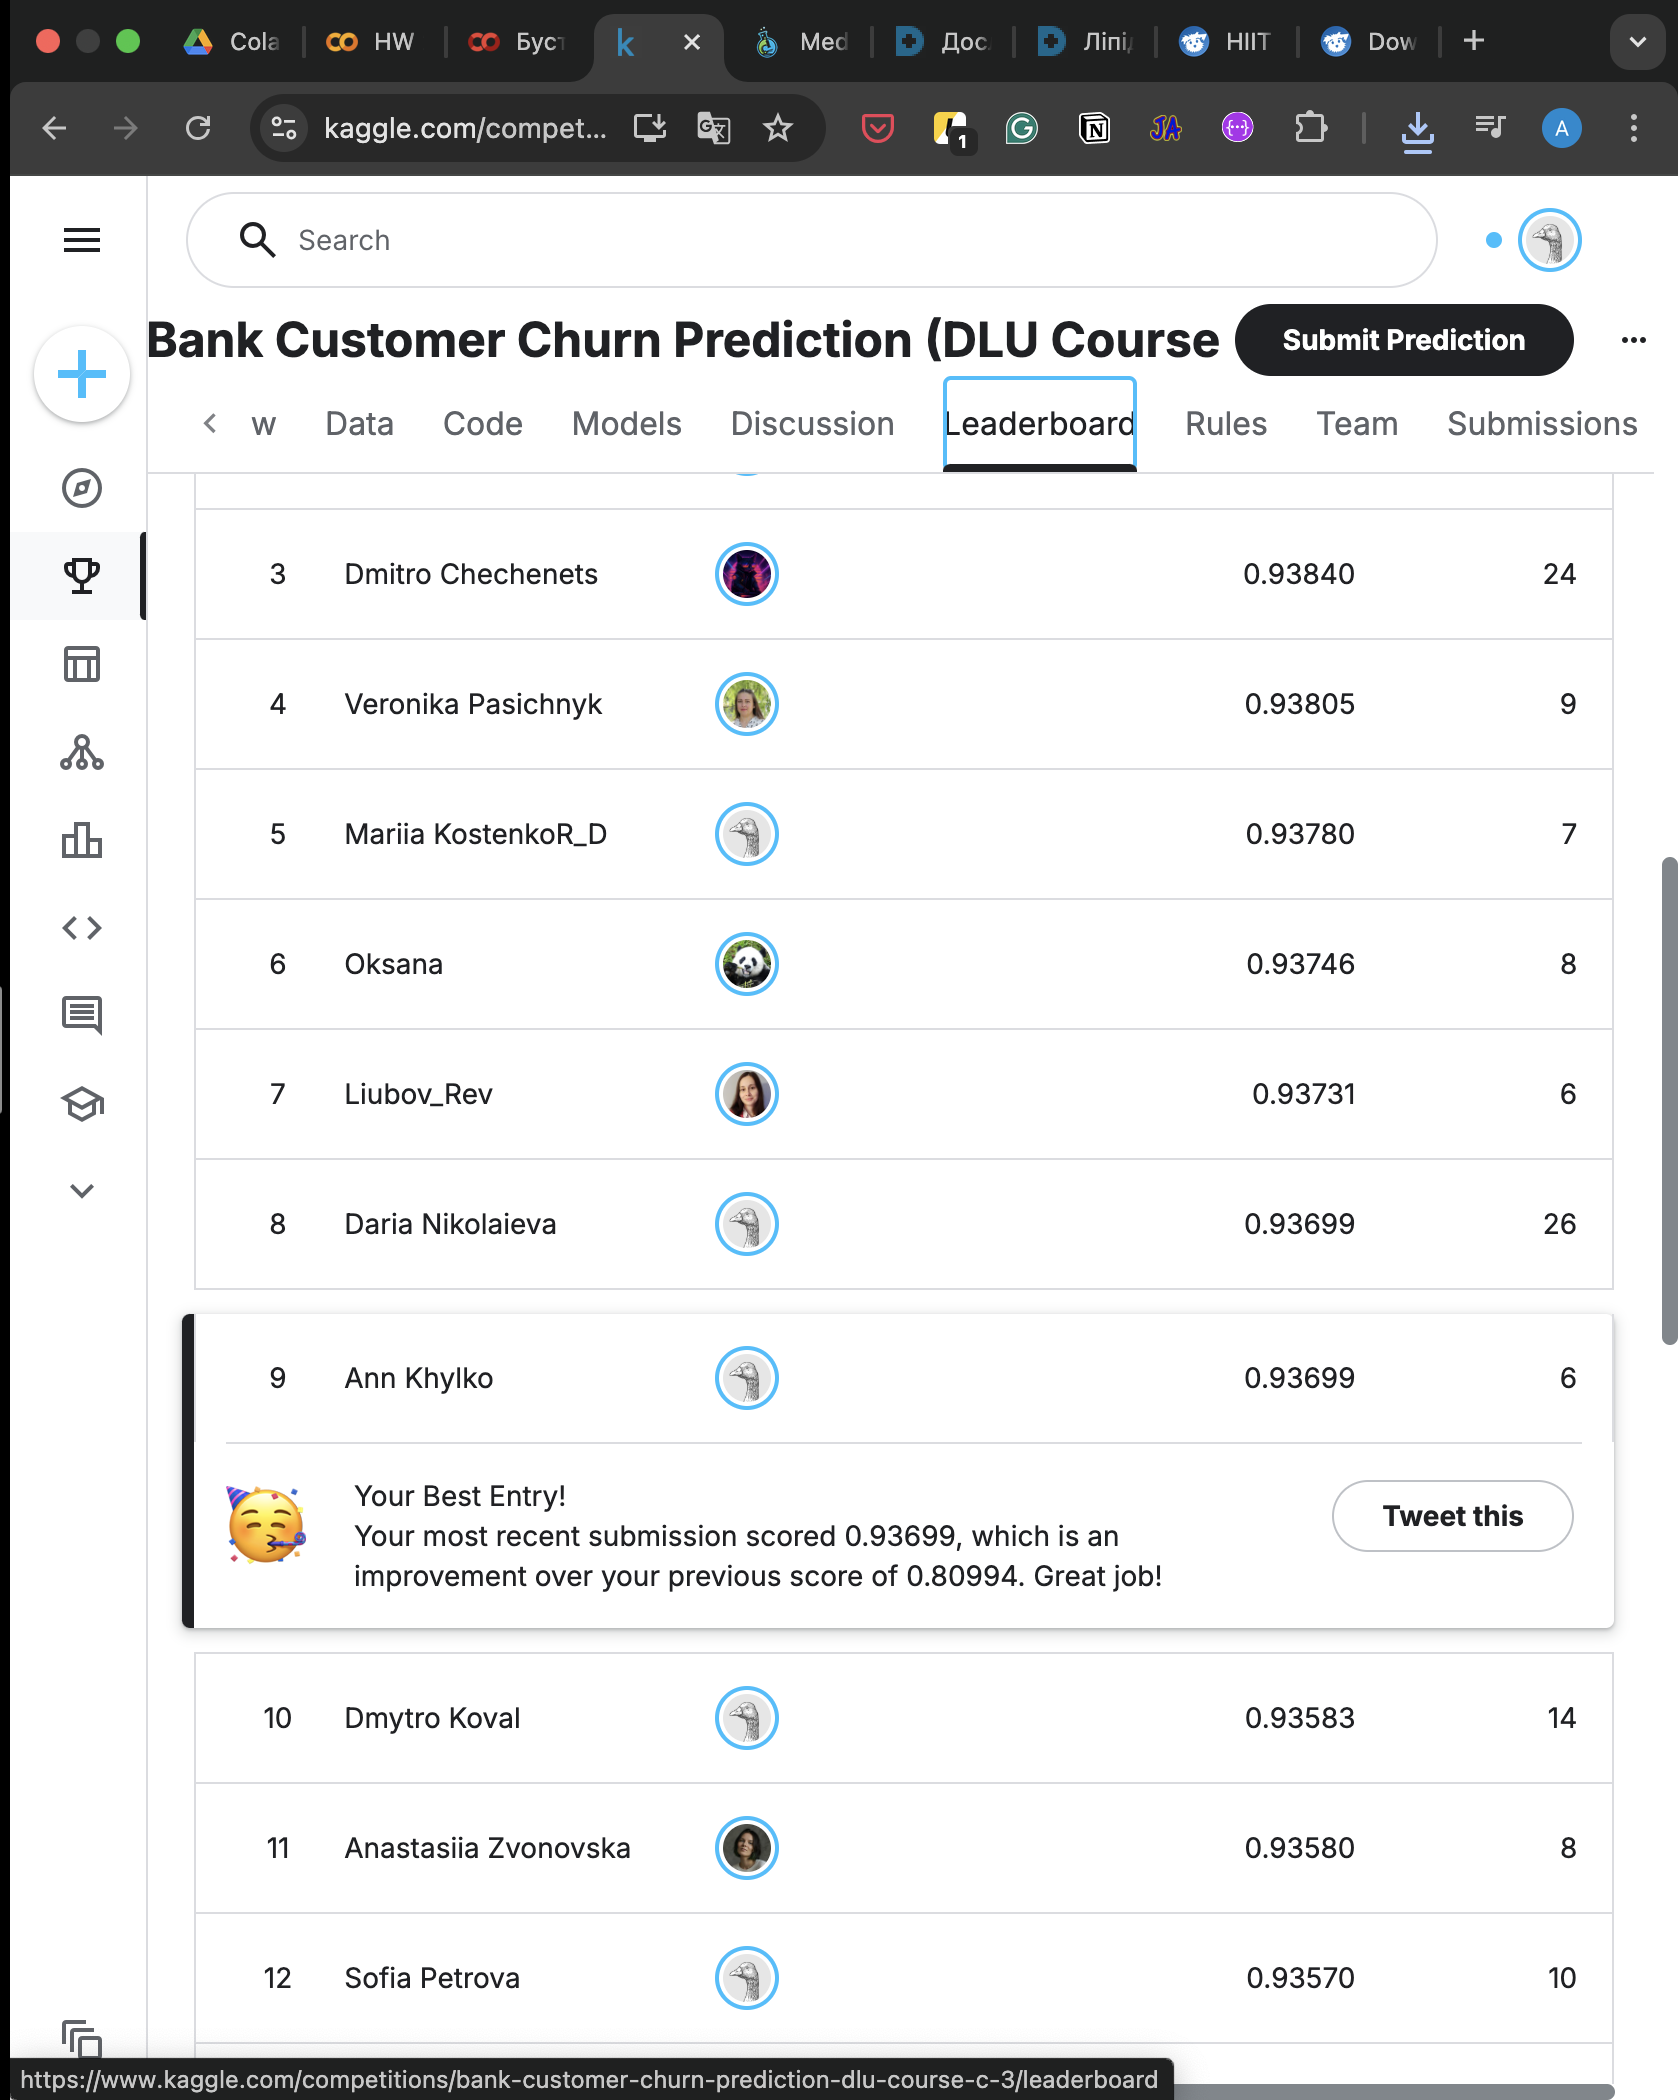